# Neural Networks with PyTorch

In this assignment, we are going to train a Neural Networks on the Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But we will flatten them to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset.

<img src='https://drive.google.com/uc?id=16TqEl9ESfXYbUpVafXD6h5UpJYGKfMxE' width="500" height="200">

Your goal is to run at least 3 experiments and get a model that can achieve 80% accuracy with not much overfitting on this dataset.

Some of the code have already been defined for you. You need only to add your code in the sections specified (marked with **TODO**). Some assert statements have been added to verify the expected outputs are correct. If it does throw an error, this means your implementation is behaving as expected.

Note: You can only use fully-connected and dropout layers for this assignment. You can not convolution layers for instance

# 1. Import Required Packages

[1.1] We are going to use numpy, matplotlib and google.colab packages

In [8]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# 2. Download Dataset

We will store the dataset into your personal Google Drive.


[2.1] Mount Google Drive

In [9]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[2.2] Create a folder called `DL_ASG_1` on your Google Drive at the root level

In [ ]:
! mkdir -p /content/gdrive/MyDrive/ColabNotebooks/UTS_III/DL/ASSIGNMENTS/DL_ASG_1

[2.3] Navigate to this folder

In [ ]:
%cd '/content/gdrive/MyDrive/ColabNotebooks/UTS_III/DL/ASSIGNMENTS/DL_ASG_1'

/content/gdrive/MyDrive/ColabNotebooks/UTS_III/DL/ASSIGNMENTS/DL_ASG_1


[2.4] Show the list of item on the folder

In [ ]:
!ls

[2.4] Dowload the dataset files to your Google Drive if required

In [ ]:
import requests
from tqdm import tqdm
import os.path

def download_file(url):
    path = url.split('/')[-1]
    if os.path.isfile(path):
        print (f"{path} already exists")
    else:
      r = requests.get(url, stream=True)
      with open(path, 'wb') as f:
          total_length = int(r.headers.get('content-length'))
          print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))
          for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
              if chunk:
                  f.write(chunk)

url_list = [
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
]

for url in url_list:
    download_file(url)

kmnist-train-imgs.npz already exists
kmnist-train-labels.npz already exists
kmnist-test-imgs.npz already exists
kmnist-test-labels.npz already exists


[2.5] List the content of the folder and confirm files have been dowloaded properly

In [10]:
! ls

kmnist-test-imgs.npz  kmnist-test-labels.npz  kmnist-train-imgs.npz  kmnist-train-labels.npz


# 3. Load Data

[3.1] Import the required modules from PyTorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim

[3.2] **TODO** Create 2 variables called `img_height` and `img_width` that will both take the value 28

In [12]:
img_height = 28
img_width = 28

[3.3] Create a function that loads a .npz file using numpy and return the content of the `arr_0` key

In [13]:
def load(f):
    return np.load(f)['arr_0']

[3.4] **TODO** Load the 4 files saved on your Google Drive into their respective variables: x_train, y_train, x_test and y_test

In [14]:
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

[3.5] **TODO** Using matplotlib display the first image from the train set and its target value

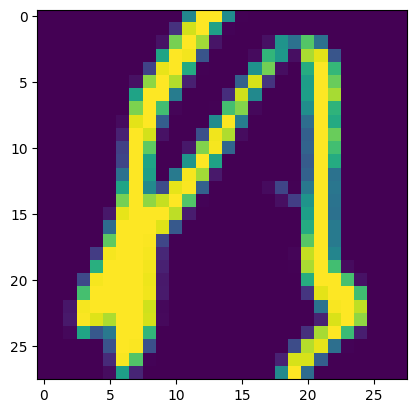

In [15]:
plt.imshow(x_train[0])

# 4. Prepare Data

[4.1] **TODO** Reshape the images from the training and testing set to have the channel dimension last. The dimensions should be: (row_number, height, width, channel)

In [16]:
x_train = torch.tensor(x_train).unsqueeze(-1)
x_test = torch.tensor(x_test).unsqueeze(-1)
x_train.shape, x_test.shape

(torch.Size([60000, 28, 28, 1]), torch.Size([10000, 28, 28, 1]))

[4.2] **TODO** Cast `x_train` and `x_test` into `float32` decimals

In [17]:
x_train = x_train.float()
x_test = x_test.float()

[4.3] **TODO** Standardise the images of the training and testing sets. Originally each image contains pixels with value ranging from 0 to 255. after standardisation, the new value range should be from 0 to 1.

In [18]:
x_train = x_train/255.0
x_test = x_test/255.0

[4.4] **TODO** Create a variable called `num_classes` that will take the value 10 which corresponds to the number of classes for the target variable

In [19]:
num_classes = 10

[4.5] **TODO** Convert the target variable for the training and testing sets to a binary class matrix of dimension (rows, num_classes).

For example:
- class 0 will become [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- class 1 will become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
- class 5 will become [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
- class 9 will become [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [20]:
# Changing target variable to binary class matrix
y_train = F.one_hot(torch.tensor(y_train, dtype=torch.int64), num_classes=num_classes)
y_test = F.one_hot(torch.tensor(y_test, dtype=torch.int64), num_classes=num_classes)

# 5. Define Neural Networks Architecure

[5.1] Set the seed in PyTorch for reproducing results



In [21]:
torch.manual_seed(42)

# Experiment 1

[5.2] **TODO** Define the architecture of your Neural Networks and save it into a variable called `model`

In [22]:
# model without dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [23]:
# model with dropout
class MLP_dropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP_dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
input_size = img_height * img_width
hidden_size = 128

In [25]:
# initializing model
model = MLP(input_size, hidden_size, num_classes)
model1 =  MLP_dropout(input_size, hidden_size, num_classes)

[5.2] **TODO** Print the summary of your model

In [26]:
# display the architecture of the model
model, model1

(MLP(
   (fc1): Linear(in_features=784, out_features=128, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ),
 MLP_dropout(
   (fc1): Linear(in_features=784, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ))

# 6. Train Neural Networks

[6.1] **TODO** Create 2 variables called `batch_size` and `epochs` that will  respectively take the values 128 and 500

In [ ]:
# defining batch_size and epochs
batch_size = 128
epochs = 500

[6.2] **TODO** Compile your model with the appropriate loss function, the optimiser of your choice and the accuracy metric

In [ ]:
criterion = nn.CrossEntropyLoss()

# Experiment 1
optimizer_1 = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# creating early stopping
class EarlyStopping:
  def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
    self.patience = patience # waiting time for early stop
    self.delta = delta # minimum change required
    self.path = path #path to save model
    self.counter = 0 # counting
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf

  def __call__(self, val_loss, model):
    score = -val_loss

    # initial case where we haven't set the best score yet.
    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)

    # if no improvement, increment counter.
    elif score < self.best_score + self.delta:
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

      # trigger early stopping if patience has been exceeded.
      if self.counter >= self.patience:
          self.early_stop = True

    # if improvement is observed, reset counter and update best score.
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0
  # save checkpoint
  def save_checkpoint(self, val_loss, model):
    if val_loss < self.val_loss_min:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(), self.path)
      self.val_loss_min = val_loss

[6.3] **TODO** Train your model
using the number of epochs defined. Calculate the total loss and save it to a variable called total_loss.

In [ ]:
def train_model(model, optimizer, criterion, epochs, earlystop = False):
  # Lists to store training and validation losses
  train_losses = []
  val_losses = []

  # Lists to store accuracies of training and validation
  train_acc = []
  val_acc = []
  early_stopping = EarlyStopping()

  # Iterate over training data batches
  for epoch in range(epochs):
      model.train() # Set model to training mode
      running_loss = 0.0
      total_train = 0
      correct_train = 0
      for inputs, labels in dataloader_train:
          optimizer.zero_grad() # Clear gradients
          outputs = model(inputs) # forward pass
          loss = criterion(outputs.double(), labels.double()) # Compute loss
          loss.backward() # backward pass
          optimizer.step() # update weights
          running_loss += loss.item()

          # compute training accuracy
          _, predicted = torch.max(outputs.data, 1)
          _, target = torch.max(labels.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == target).sum().item()

      train_accuracy = 100 * correct_train / total_train
      train_loss = running_loss / len(dataloader_train)
      train_losses.append(train_loss)
      train_acc.append(train_accuracy)

      # validation
      correct_val = 0
      total_val = 0
      val_loss = 0.0
      with torch.no_grad(): # disable gradient computation for validation
          for inputs, labels in dataloader_val:
              outputs = model(inputs)
              loss = criterion(outputs.double(), labels.double())
              val_loss += loss.item()
              total_val += labels.size(0)

              # Compute validation accuracy
              _, predicted = torch.max(outputs.data, 1)
              _, target = torch.max(labels.data, 1)
              correct_val += (predicted == target).sum().item()

      val_accuracy = 100 * correct_val / total_val
      val_loss /= len(dataloader_test)
      val_losses.append(val_loss)
      val_acc.append(val_accuracy)
      print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f},",
            f"Training Accuracy: {train_accuracy:.2f}%",
            f"Validation Loss: {val_loss:.4f},",
            f"Validation Accuracy: {val_accuracy:.2f}%")

      # early stopping
      if earlystop:
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
  return model, train_losses, val_losses, train_acc, val_acc

In [ ]:
model_exp1, train_losses_1, val_losses_1, train_acc_1, val_acc_1 = train_model(model, optimizer_1, criterion, epochs)

Epoch [1/500], Training Loss: 2.2716, Training Accuracy: 17.66% Validation Loss: 2.6626, Validation Accuracy: 25.68%
Epoch [2/500], Training Loss: 2.2022, Training Accuracy: 34.02% Validation Loss: 2.5749, Validation Accuracy: 40.28%
Epoch [3/500], Training Loss: 2.1250, Training Accuracy: 45.67% Validation Loss: 2.4765, Validation Accuracy: 50.03%
Epoch [4/500], Training Loss: 2.0394, Training Accuracy: 52.15% Validation Loss: 2.3693, Validation Accuracy: 54.97%
Epoch [5/500], Training Loss: 1.9479, Training Accuracy: 55.96% Validation Loss: 2.2573, Validation Accuracy: 58.52%
Epoch [6/500], Training Loss: 1.8543, Training Accuracy: 59.38% Validation Loss: 2.1453, Validation Accuracy: 61.09%
Epoch [7/500], Training Loss: 1.7620, Training Accuracy: 61.88% Validation Loss: 2.0364, Validation Accuracy: 64.07%
Epoch [8/500], Training Loss: 1.6735, Training Accuracy: 64.31% Validation Loss: 1.9332, Validation Accuracy: 65.83%
Epoch [9/500], Training Loss: 1.5902, Training Accuracy: 65.87% 

[6.4] **TODO** Test your model.  Initiate the model.eval() along with torch.no_grad() to turn off the gradients.


In [ ]:
def test_model(model, criterion):
  predicted_labels = []
  true_labels = []

  # evaluating test set
  model.eval()
  running_loss = 0.0
  correct_test = 0
  total_test = 0
  with torch.no_grad():
    for inputs, labels in dataloader_test:
      outputs = model(inputs)
      loss = criterion(outputs.double(), labels.double())  # Compute the loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      _, target = torch.max(labels.data, 1)
      total_test += labels.size(0)

      #  checking accuracy on test set
      correct_test += (predicted == target).sum().item()
      predicted_labels.extend(predicted.tolist())
      true_labels.extend(target.tolist())
  test_loss = running_loss / len(dataloader_test)
  test_accuracy = 100 * correct_test / total_test
  print(f"Accuracy on the test set: {test_accuracy:.2f}%\n",
        f"Loss on test set : {test_loss}")
  return predicted_labels, true_labels

In [ ]:
predicted_labels_1, true_labels_1 = test_model(model_exp1, criterion) # test model

Accuracy on the test set: 81.49%
 Loss on test set : 0.5965329275025546


# Experiment 2


In [ ]:
model = MLP(input_size, hidden_size, num_classes) #initialize model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # initialize optimizer
model_exp2, train_losses_2, val_losses_2, train_acc_2, val_acc_2 = train_model(model, optimizer, criterion, epochs) # train_model

Epoch [1/500], Training Loss: 1.9494, Training Accuracy: 45.50% Validation Loss: 1.8177, Validation Accuracy: 65.74%
Epoch [2/500], Training Loss: 1.2526, Training Accuracy: 70.03% Validation Loss: 1.2322, Validation Accuracy: 73.86%
Epoch [3/500], Training Loss: 0.9310, Training Accuracy: 74.97% Validation Loss: 0.9926, Validation Accuracy: 77.55%
Epoch [4/500], Training Loss: 0.7847, Training Accuracy: 78.26% Validation Loss: 0.8714, Validation Accuracy: 79.70%
Epoch [5/500], Training Loss: 0.7031, Training Accuracy: 80.12% Validation Loss: 0.7978, Validation Accuracy: 81.10%
Epoch [6/500], Training Loss: 0.6512, Training Accuracy: 81.37% Validation Loss: 0.7485, Validation Accuracy: 82.03%
Epoch [7/500], Training Loss: 0.6137, Training Accuracy: 82.25% Validation Loss: 0.7125, Validation Accuracy: 82.67%
Epoch [8/500], Training Loss: 0.5857, Training Accuracy: 82.90% Validation Loss: 0.6846, Validation Accuracy: 83.17%
Epoch [9/500], Training Loss: 0.5626, Training Accuracy: 83.56% 

In [ ]:
predicted_labels_2, true_labels_2 = test_model(model_exp2, criterion) # test model with test dataset

Accuracy on the test set: 88.11%
 Loss on test set : 0.5085550009326433


# Expermient 3

In [ ]:
model = MLP_dropout(input_size, hidden_size, num_classes) # initialize model for exp 3
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # optimizer
model_exp3, train_losses_3, val_losses_3, train_acc_3, val_acc_3 = train_model(model, optimizer, criterion, epochs, earlystop=True) # train Model

Epoch [1/500], Training Loss: 1.9784, Training Accuracy: 40.48% Validation Loss: 1.9151, Validation Accuracy: 57.00%
Validation loss decreased (inf --> 1.915120).  Saving model ...
Epoch [2/500], Training Loss: 1.3840, Training Accuracy: 61.66% Validation Loss: 1.4297, Validation Accuracy: 65.59%
Validation loss decreased (1.915120 --> 1.429659).  Saving model ...
Epoch [3/500], Training Loss: 1.0974, Training Accuracy: 68.60% Validation Loss: 1.2015, Validation Accuracy: 70.86%
Validation loss decreased (1.429659 --> 1.201464).  Saving model ...
Epoch [4/500], Training Loss: 0.9624, Training Accuracy: 72.06% Validation Loss: 1.0742, Validation Accuracy: 73.88%
Validation loss decreased (1.201464 --> 1.074197).  Saving model ...
Epoch [5/500], Training Loss: 0.8708, Training Accuracy: 74.61% Validation Loss: 0.9903, Validation Accuracy: 75.94%
Validation loss decreased (1.074197 --> 0.990330).  Saving model ...
Epoch [6/500], Training Loss: 0.8192, Training Accuracy: 75.83% Validation 

In [ ]:
model_exp3 = MLP_dropout(input_size, hidden_size, num_classes)  # model 3
model_exp3.load_state_dict(torch.load('checkpoint.pt')) # load model
predicted_labels_3, true_labels_3 = test_model(model_exp3, criterion) # test model

Accuracy on the test set: 83.34%
 Loss on test set : 0.5388133946206495


# Experiment 4

In [ ]:
model = MLP(input_size, hidden_size, num_classes) # initialize model for exp4
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #optimizer
model_exp4, train_losses_4, val_losses_4, train_acc_4, val_acc_4 = train_model(model, optimizer, criterion, epochs, earlystop=True) # train model with earlystop

Epoch [1/500], Training Loss: 1.9304, Training Accuracy: 46.26% Validation Loss: 1.7774, Validation Accuracy: 67.79%
Validation loss decreased (inf --> 1.777387).  Saving model ...
Epoch [2/500], Training Loss: 1.2283, Training Accuracy: 70.05% Validation Loss: 1.2168, Validation Accuracy: 73.67%
Validation loss decreased (1.777387 --> 1.216829).  Saving model ...
Epoch [3/500], Training Loss: 0.9251, Training Accuracy: 74.81% Validation Loss: 0.9935, Validation Accuracy: 77.19%
Validation loss decreased (1.216829 --> 0.993526).  Saving model ...
Epoch [4/500], Training Loss: 0.7890, Training Accuracy: 77.92% Validation Loss: 0.8794, Validation Accuracy: 79.55%
Validation loss decreased (0.993526 --> 0.879394).  Saving model ...
Epoch [5/500], Training Loss: 0.7129, Training Accuracy: 79.63% Validation Loss: 0.8091, Validation Accuracy: 80.59%
Validation loss decreased (0.879394 --> 0.809137).  Saving model ...
Epoch [6/500], Training Loss: 0.6628, Training Accuracy: 80.90% Validation 

In [ ]:
model_exp4 = MLP_dropout(input_size, hidden_size, num_classes)
model_exp4.load_state_dict(torch.load('checkpoint.pt')) # load model
predicted_labels_4, true_labels_4 = test_model(model_exp4, criterion) #test model

Accuracy on the test set: 87.47%
 Loss on test set : 0.44611690859974557


# 7. Analyse Results

[7.1] **TODO** Display the performance of your model on the training and testing sets

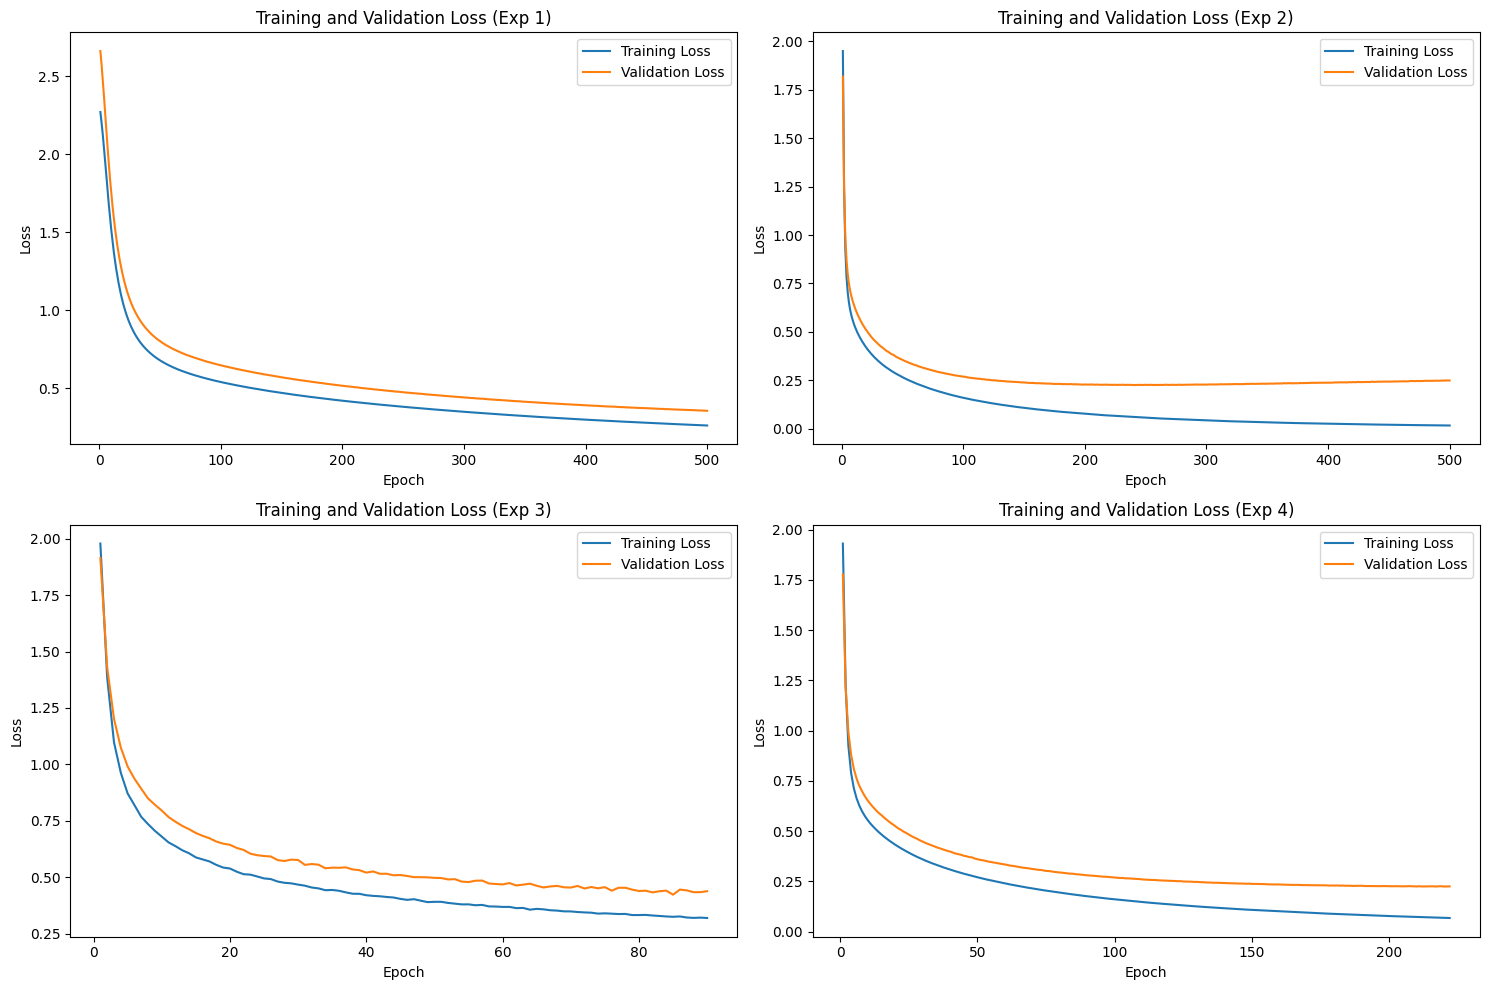

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the figure size as needed

# Plot for Experiment 1
axs[0, 0].plot(range(1, epochs + 1), train_losses_1, label='Training Loss')
axs[0, 0].plot(range(1, epochs + 1), val_losses_1, label='Validation Loss')
axs[0, 0].set_title('Training and Validation Loss (Exp 1)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot for Experiment 2
axs[0, 1].plot(range(1, epochs + 1), train_losses_2, label='Training Loss')
axs[0, 1].plot(range(1, epochs + 1), val_losses_2, label='Validation Loss')
axs[0, 1].set_title('Training and Validation Loss (Exp 2)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot for Experiment 3
axs[1, 0].plot(range(1, len(train_losses_3) + 1), train_losses_3, label='Training Loss')
axs[1, 0].plot(range(1, len(val_losses_3) + 1), val_losses_3, label='Validation Loss')
axs[1, 0].set_title('Training and Validation Loss (Exp 3)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot for Experiment 4
axs[1, 1].plot(range(1, len(train_losses_4) + 1), train_losses_4, label='Training Loss')
axs[1, 1].plot(range(1, len(val_losses_4) + 1), val_losses_4, label='Validation Loss')
axs[1, 1].set_title('Training and Validation Loss (Exp 4)')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

[7.2] **TODO** Plot the learning curve of your model

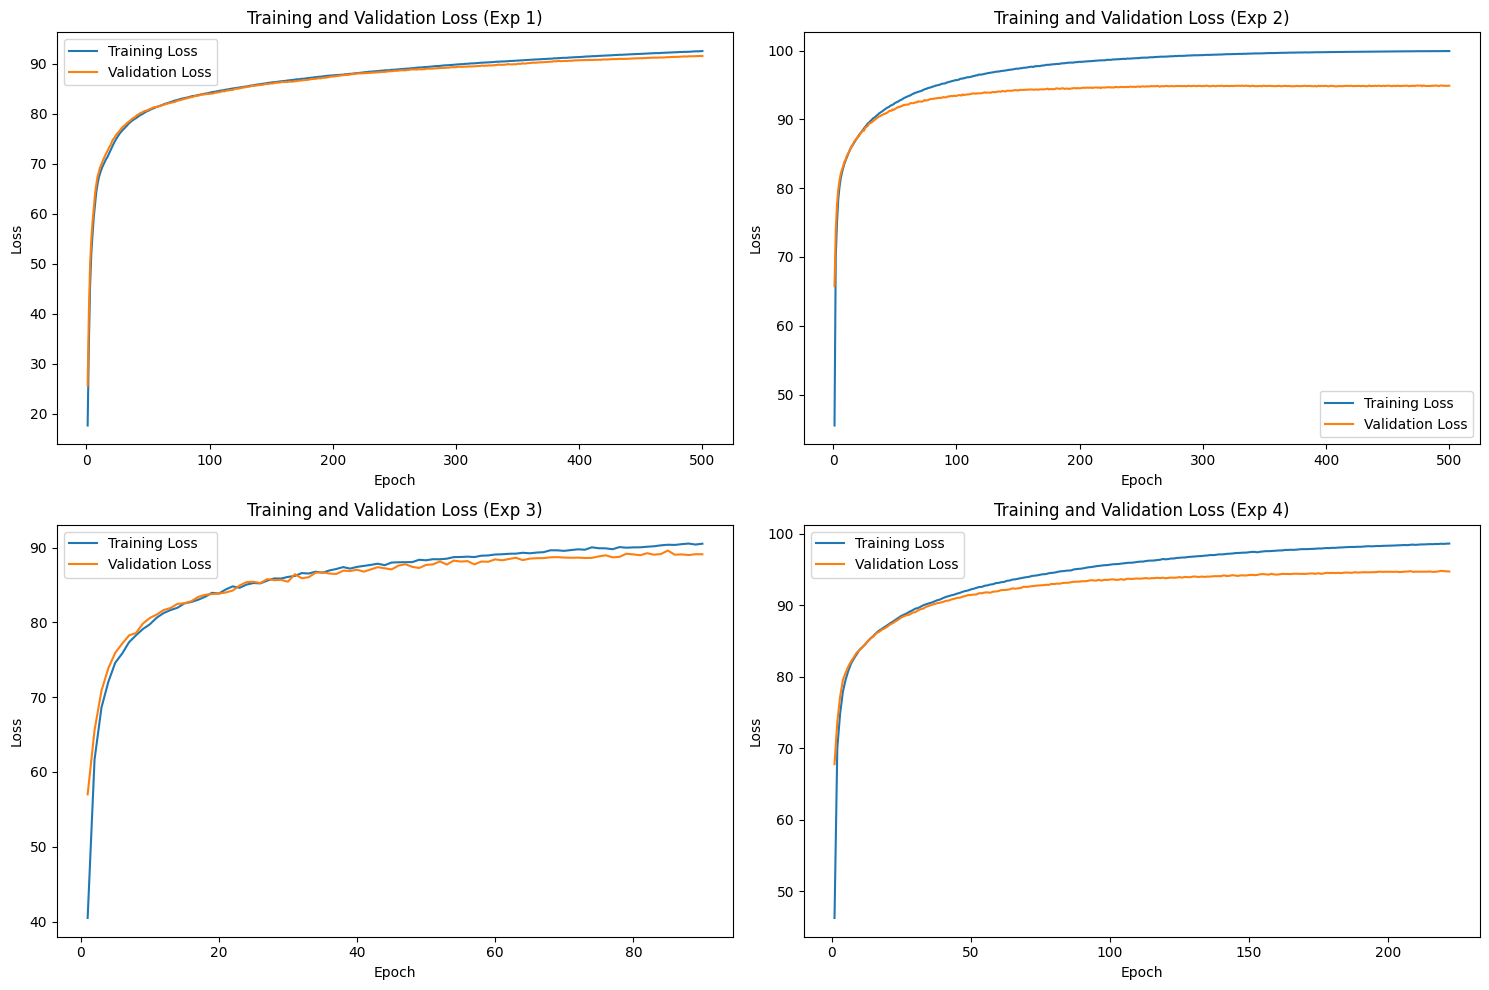

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the figure size as needed

# Plot for Experiment 1
axs[0, 0].plot(range(1, epochs + 1), train_acc_1, label='Training Loss')
axs[0, 0].plot(range(1, epochs + 1), val_acc_1, label='Validation Loss')
axs[0, 0].set_title('Training and Validation Loss (Exp 1)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot for Experiment 2
axs[0, 1].plot(range(1, epochs + 1), train_acc_2, label='Training Loss')
axs[0, 1].plot(range(1, epochs + 1), val_acc_2, label='Validation Loss')
axs[0, 1].set_title('Training and Validation Loss (Exp 2)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot for Experiment 3
axs[1, 0].plot(range(1, len(train_acc_3) + 1), train_acc_3, label='Training Loss')
axs[1, 0].plot(range(1, len(val_acc_3) + 1), val_acc_3, label='Validation Loss')
axs[1, 0].set_title('Training and Validation Loss (Exp 3)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot for Experiment 4
axs[1, 1].plot(range(1, len(train_acc_4) + 1), train_acc_4, label='Training Loss')
axs[1, 1].plot(range(1, len(val_acc_4) + 1), val_acc_4, label='Validation Loss')
axs[1, 1].set_title('Training and Validation Loss (Exp 4)')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

[7.3] **TODO** Display the confusion matrix on the testing set predictions

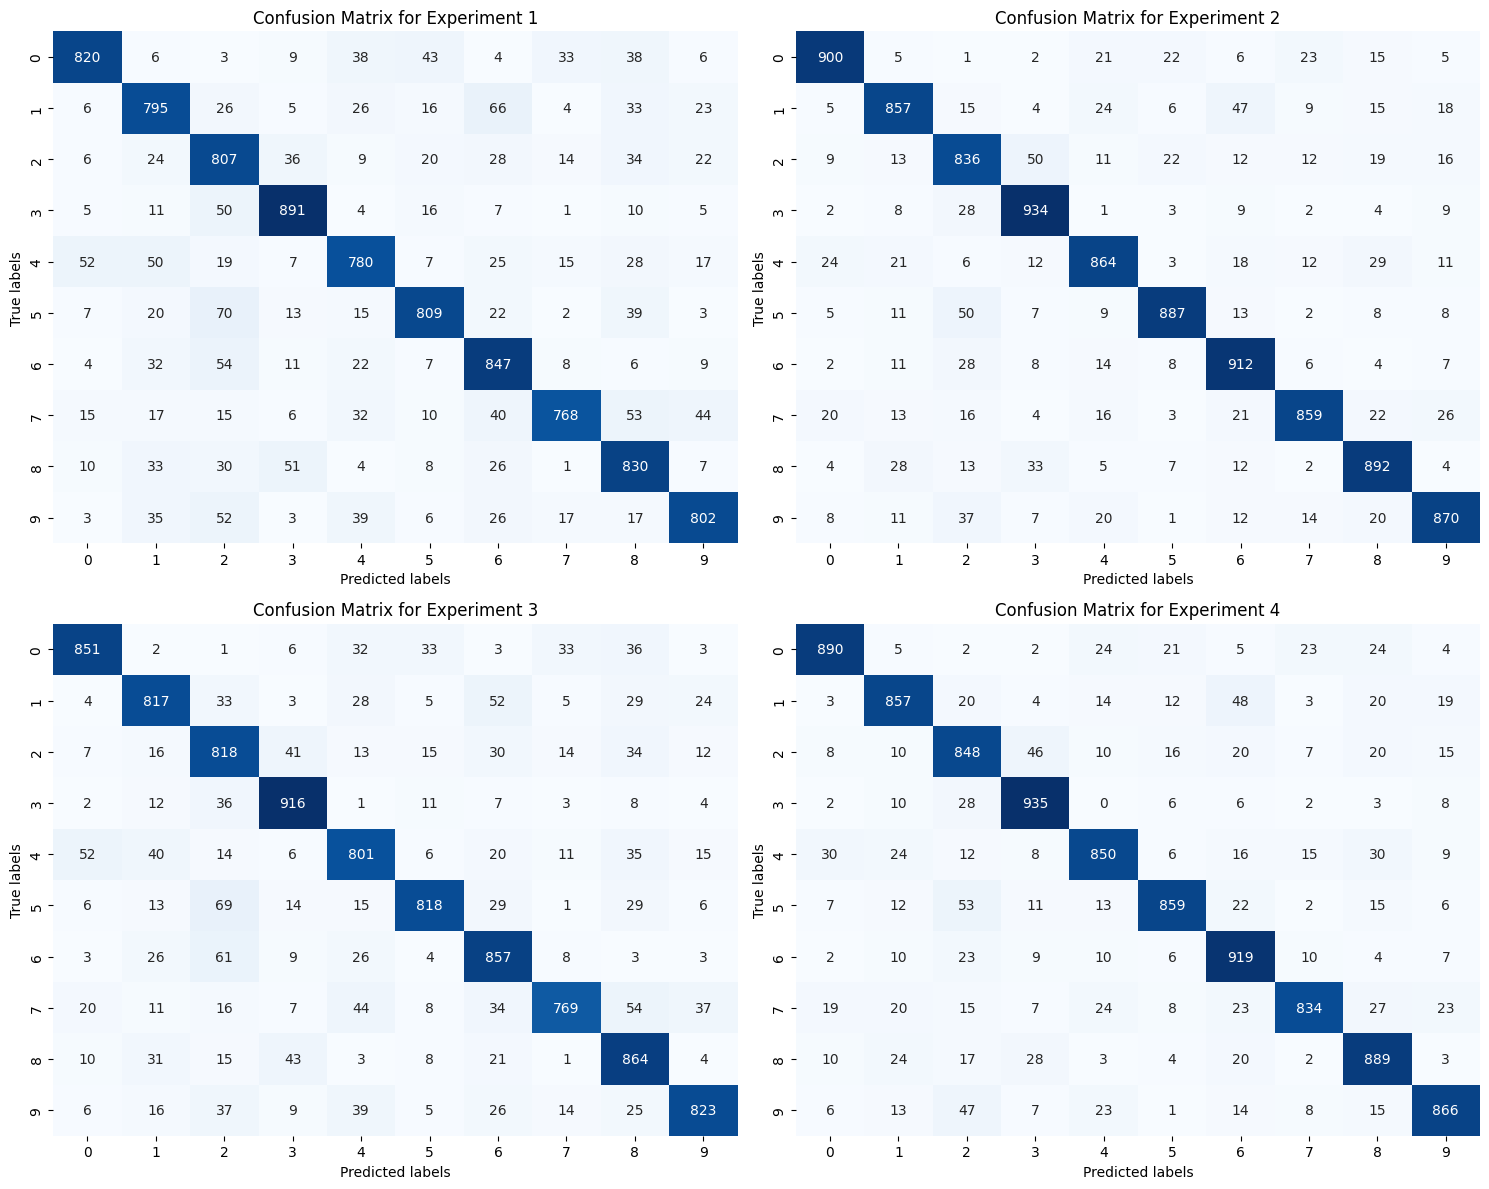

In [ ]:
# TODO (Students need to fill this section)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the size as needed

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Create a list of labels for your confusion matrices
labels = [true_labels_1, true_labels_2, true_labels_3, true_labels_4]
predictions = [predicted_labels_1, predicted_labels_2, predicted_labels_3, predicted_labels_4]

for i, (true, predicted) in enumerate(zip(labels, predictions)):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true, predicted)

    # Use seaborn to create a heatmap for the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes_flat[i])

    # Label the axes
    axes_flat[i].set_xlabel('Predicted labels')
    axes_flat[i].set_ylabel('True labels')

    # Title for each subplot with dynamic experiment number
    axes_flat[i].set_title(f'Confusion Matrix for Experiment {i+1}')

# Adjust the layout to prevent label overlap
plt.tight_layout()

# Display the plot
plt.show()
